<a href="https://colab.research.google.com/github/jverho/SSI-Biometric-Authentication/blob/main/GeneralGermanBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install transformers datasets accelerate -q
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
# Make sure ETSP directory is on the path for module imports
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ETSP/utils')
from prepare_dataset import make_datasets
# Disable WandB
os.environ["WANDB_DISABLED"] = "true"

# Set file path and dialects
file_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/sentences_ch_de_transcribed.json'
dialects = ['ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu']

# Load datasets and label mappings
train_dataset, val_dataset, test_dataset, dialect2label, _, _, _ = make_datasets(file_path, dialects)
label2dialect = {i: d for d, i in dialect2label.items()}

Mounted at /content/drive


In [ ]:
# Print class distribution
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)
test_df = pd.DataFrame(test_dataset)

print("Train distribution:")
print(train_df['label'].value_counts())
print("Validation distribution:")
print(val_df['label'].value_counts())
print("Test distribution:")
print(test_df['label'].value_counts())

Train distribution:
label
0    2022
1    2022
2    2022
3    2022
4    2022
5    2022
6    2022
7    2022
Name: count, dtype: int64
Validation distribution:
label
0    253
1    253
2    253
3    253
4    253
5    253
6    253
7    253
Name: count, dtype: int64
Test distribution:
label
0    253
1    253
2    253
3    253
4    253
5    253
6    253
7    253
Name: count, dtype: int64


In [ ]:
# Model and Tokenizer
model_name = "bert-base-german-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(dialects))

def tokenize_fn(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

# --- 8. Set format for PyTorch ---
for ds in [train_dataset, val_dataset, test_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16176 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

In [ ]:
# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    report = classification_report(labels, predictions, target_names=list(label2dialect.values()), output_dict=True)
    metrics = {
        'accuracy': accuracy,
        'macro_f1': report['macro avg']['f1-score']
    }
    for i, dialect in label2dialect.items():
        metrics[f'f1_{dialect}'] = report[dialect]['f1-score']
        metrics[f'precision_{dialect}'] = report[dialect]['precision']
        metrics[f'recall_{dialect}'] = report[dialect]['recall']
    return metrics

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-swissdial-results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    num_train_epochs=3,
    logging_dir="./logs",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Initialize Trainer and Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1498790472.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Ch Sg,Precision Ch Sg,Recall Ch Sg,F1 Ch Be,Precision Ch Be,Recall Ch Be,F1 Ch Gr,Precision Ch Gr,Recall Ch Gr,F1 Ch Zh,Precision Ch Zh,Recall Ch Zh,F1 Ch Vs,Precision Ch Vs,Recall Ch Vs,F1 Ch Bs,Precision Ch Bs,Recall Ch Bs,F1 Ch Ag,Precision Ch Ag,Recall Ch Ag,F1 Ch Lu,Precision Ch Lu,Recall Ch Lu
1,0.560500,0.488417,0.805830,0.808137,0.699213,0.581152,0.877470,0.900415,0.947598,0.857708,0.910537,0.916000,0.905138,0.685225,0.747664,0.632411,0.948413,0.952191,0.944664,0.783550,0.866029,0.715415,0.757709,0.855721,0.679842,0.780037,0.732639,0.833992
2,0.328200,0.421378,0.846838,0.847456,0.795082,0.825532,0.766798,0.904564,0.951965,0.861660,0.920949,0.920949,0.920949,0.750507,0.770833,0.731225,0.955285,0.983264,0.928854,0.814953,0.773050,0.861660,0.830540,0.785211,0.881423,0.807767,0.793893,0.822134
3,0.236700,0.398422,0.865613,0.865752,0.810811,0.792453,0.830040,0.920570,0.949580,0.893281,0.925197,0.921569,0.928854,0.783838,0.801653,0.766798,0.974052,0.983871,0.964427,0.837294,0.778912,0.905138,0.847584,0.800000,0.901186,0.826667,0.944162,0.735178
4,0.153700,0.415677,0.871047,0.871820,0.807018,0.796154,0.818182,0.932238,0.970085,0.897233,0.929577,0.946721,0.913043,0.794727,0.758993,0.833992,0.964706,0.957198,0.972332,0.857143,0.848837,0.865613,0.838574,0.892857,0.790514,0.850575,0.825279,0.877470
5,0.102900,0.453772,0.879941,0.880657,0.819923,0.795539,0.845850,0.934959,0.962343,0.909091,0.938124,0.947581,0.928854,0.798464,0.776119,0.822134,0.970414,0.968504,0.972332,0.857143,0.848837,0.865613,0.866142,0.862745,0.869565,0.860082,0.896996,0.826087


TrainOutput(global_step=5055, training_loss=0.32625596058710626, metrics={'train_runtime': 1890.963, 'train_samples_per_second': 42.772, 'train_steps_per_second': 2.673, 'total_flos': 5320392141864960.0, 'train_loss': 0.32625596058710626, 'epoch': 5.0})

Test set metrics: {'eval_loss': 0.3198646605014801, 'eval_accuracy': 0.8858695652173914, 'eval_macro_f1': 0.8862419331036149, 'eval_f1_ch_sg': 0.8206106870229007, 'eval_precision_ch_sg': 0.7933579335793358, 'eval_recall_ch_sg': 0.849802371541502, 'eval_f1_ch_be': 0.9442231075697212, 'eval_precision_ch_be': 0.9518072289156626, 'eval_recall_ch_be': 0.9367588932806324, 'eval_f1_ch_gr': 0.9322709163346613, 'eval_precision_ch_gr': 0.9397590361445783, 'eval_recall_ch_gr': 0.924901185770751, 'eval_f1_ch_zh': 0.8396624472573839, 'eval_precision_ch_zh': 0.9004524886877828, 'eval_recall_ch_zh': 0.7865612648221344, 'eval_f1_ch_vs': 0.964, 'eval_precision_ch_vs': 0.9757085020242915, 'eval_recall_ch_vs': 0.9525691699604744, 'eval_f1_ch_bs': 0.8403669724770643, 'eval_precision_ch_bs': 0.7842465753424658, 'eval_recall_ch_bs': 0.9051383399209486, 'eval_f1_ch_ag': 0.8855534709193246, 'eval_precision_ch_ag': 0.8428571428571429, 'eval_recall_ch_ag': 0.932806324110672, 'eval_f1_ch_lu': 0.8632478632478633,

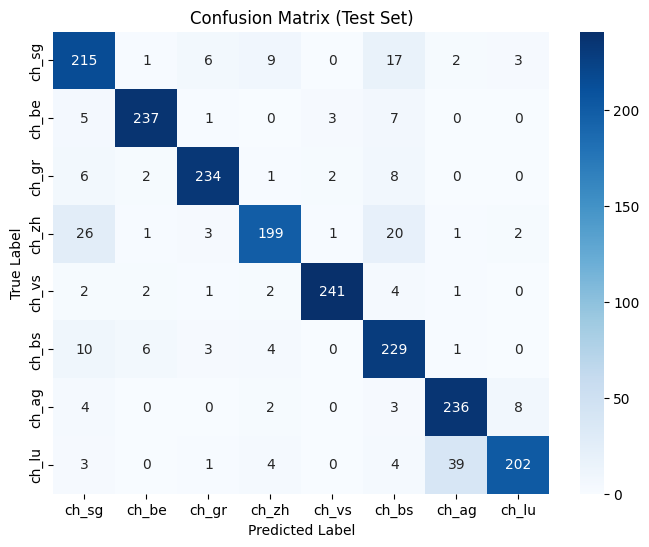

In [ ]:
# Evaluate on test set and show confusion matrix + classification report
results = trainer.evaluate(test_dataset)
print("Test set metrics:", results)
print("Label mapping:", label2dialect)

# Predict on test set
outputs = trainer.predict(test_dataset)
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=list(label2dialect.values())))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label2dialect.values()), yticklabels=list(label2dialect.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()